In [12]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow import keras
from keras import Input
from keras.models import Model, load_model, save_model
from keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [13]:
im_width = 256
im_height = 256


# **PATHS**

In [14]:
train_files = []
mask_files = glob('/kaggle/input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

print(train_files[:10])
print(mask_files[:10])

['/kaggle/input/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_10.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_11.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_12.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_13.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_14.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_15.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_16.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_17.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_18.tif', '/kaggle/input/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_1996090

# **DATA VIS**

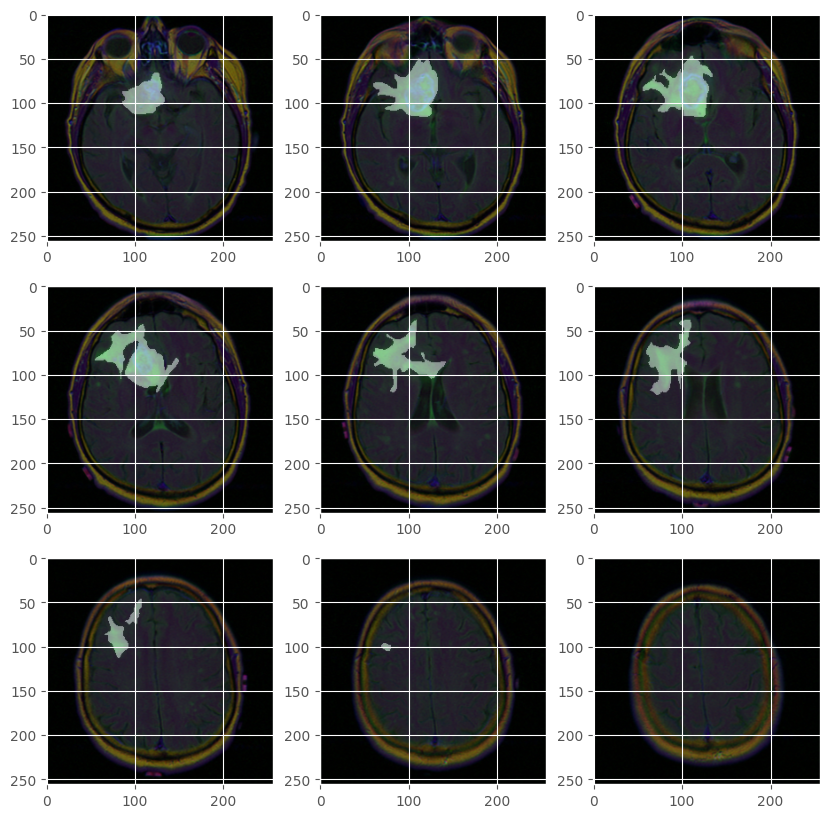

In [15]:
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=train_files[i]
    msk_path=mask_files[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk,alpha=0.4)
plt.show()

# **DATA FRAMES**

In [16]:
df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})
df_train, df_test = train_test_split(df,test_size = 0.1)
df_train, df_val = train_test_split(df_train,test_size = 0.2)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2828, 2)
(708, 2)
(393, 2)


# **DATA GEN, AUG**

In [17]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def channel_wise_min_max_normalization(image):
    # Split the image into its individual color channels
    pre_contrast_channel = image[..., 0:1]
    flair_channel = image[..., 1:2]
    post_contrast_channel = image[..., 2:3]

    # Process each channel as needed
    # ...
    
    min_pre_contrast = np.min(pre_contrast_channel)
    max_pre_contrast = np.max(pre_contrast_channel)

    min_flair = np.min(flair_channel)
    max_flair = np.max(flair_channel)

    min_post_contrast = np.min(post_contrast_channel)
    max_post_contrast = np.max(post_contrast_channel)

    normalized_pre_contrast = (pre_contrast_channel - min_pre_contrast) / (max_pre_contrast - min_pre_contrast)
    normalized_flair = (flair_channel - min_flair) / (max_flair - min_flair)
    normalized_post_contrast = (post_contrast_channel - min_post_contrast) / (max_post_contrast - min_post_contrast)


    # Join the color channels back together
    normalized_image = tf.concat([normalized_pre_contrast, normalized_flair, normalized_post_contrast], axis=-1)


    return normalized_image

def adjust_data(img,mask):
   
    img = img / 255

    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

# **DEFINE LOSS**

In [18]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

# **UNET**

In [19]:
# def unet(input_size=(256,256,3)):
#     inputs = Input(input_size)
    
#     conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
#     bn1 = Activation('relu')(conv1)
#     conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
#     bn1 = BatchNormalization(axis=3)(conv1)
#     bn1 = Activation('relu')(bn1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

#     conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
#     bn2 = Activation('relu')(conv2)
#     conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
#     bn2 = BatchNormalization(axis=3)(conv2)
#     bn2 = Activation('relu')(bn2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

#     conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
#     bn3 = Activation('relu')(conv3)
#     conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
#     bn3 = BatchNormalization(axis=3)(conv3)
#     bn3 = Activation('relu')(bn3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

#     conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
#     bn4 = Activation('relu')(conv4)
#     conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
#     bn4 = BatchNormalization(axis=3)(conv4)
#     bn4 = Activation('relu')(bn4)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

#     conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
#     bn5 = Activation('relu')(conv5)
#     conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
#     bn5 = BatchNormalization(axis=3)(conv5)
#     bn5 = Activation('relu')(bn5)

#     up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
#     conv6 = Conv2D(512, (3, 3), padding='same')(up6)
#     bn6 = Activation('relu')(conv6)
#     conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
#     bn6 = BatchNormalization(axis=3)(conv6)
#     bn6 = Activation('relu')(bn6)

#     up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
#     conv7 = Conv2D(256, (3, 3), padding='same')(up7)
#     bn7 = Activation('relu')(conv7)
#     conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
#     bn7 = BatchNormalization(axis=3)(conv7)
#     bn7 = Activation('relu')(bn7)

#     up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
#     conv8 = Conv2D(128, (3, 3), padding='same')(up8)
#     bn8 = Activation('relu')(conv8)
#     conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
#     bn8 = BatchNormalization(axis=3)(conv8)
#     bn8 = Activation('relu')(bn8)

#     up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
#     conv9 = Conv2D(64, (3, 3), padding='same')(up9)
#     bn9 = Activation('relu')(conv9)
#     conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
#     bn9 = BatchNormalization(axis=3)(conv9)
#     bn9 = Activation('relu')(bn9)

#     conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

#     return Model(inputs=[inputs], outputs=[conv10])


def conv_block(x, num_filters):
    x = Conv2D(filters=num_filters, kernel_size=(3,3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=num_filters, kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

def up_block(x,num_filters, corr_conv):
    
    x = concatenate([Conv2DTranspose(num_filters, (2,2), strides=(2,2), padding='same')(x), corr_conv], axis=3)
    x = Conv2D(num_filters, (3,3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (3,3), padding='same')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)
    
    return x


def unet(input_size=(256, 256, 3)):
    inputs = keras.layers.Input(input_size)
    
    num_filters = [64, 128, 256, 512]
    skip_x = []
    
    x = inputs
    
    # Encoder
    for f in num_filters:
        x = conv_block(x, f)
        skip_x.append(x)
        x = MaxPooling2D(pool_size=(2,2))(x)
        
    # Bridge
    x = conv_block(x, num_filters[-1] * 2)
        
    num_filters.reverse()
    skip_x.reverse()
    
    for nr_filter, corr_conv in zip(num_filters, skip_x):
        x = up_block(x, nr_filter, corr_conv)
            
    x = Conv2D(1, (1, 1), activation='sigmoid')(x)
    return Model(inputs=[inputs], outputs=[x])

In [20]:
model = unet()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 256, 256, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 activation_36 (Activation)     (None, 256, 256, 64  0           ['conv2d_38[0][0]']              
                                )                                                           

# **Training**

In [21]:
EPOCHS = 5
BATCH_SIZE = 8
learning_rate = 1e-4

In [22]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))
    
test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
    
model = unet(input_size=(im_height, im_width, 3))



decay_rate = learning_rate / EPOCHS
opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
model.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

callbacks = [ModelCheckpoint('unet_brain_mri_seg2.h5', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/5
354/353 [==============================] - ETA: 0s - loss: -0.1661 - binary_accuracy: 0.9482 - iou: 0.0965 - dice_coef: 0.1659Found 708 validated image filenames.
Found 708 validated image filenames.

Epoch 1: val_loss improved from inf to -0.16080, saving model to unet_brain_mri_seg2.h5
353/353 [==============================] - 211s 594ms/step - loss: -0.1661 - binary_accuracy: 0.9482 - iou: 0.0965 - dice_coef: 0.1659 - val_loss: -0.1608 - val_binary_accuracy: 0.9927 - val_iou: 0.0920 - val_dice_coef: 0.1604
Epoch 2/5
354/353 [==============================] - ETA: 0s - loss: -0.3305 - binary_accuracy: 0.9897 - iou: 0.2127 - dice_coef: 0.3305
Epoch 2: val_loss improved from -0.16080 to -0.31481, saving model to unet_brain_mri_seg2.h5
353/353 [==============================] - 199s 563ms/step - loss: -0.3305 - binary_accuracy: 0.9897 - iou: 0.2127 - dice_coef: 0.3305 - val_loss: -0.3148 - val_binary_

In [ ]:
a = history.history

list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainjaccard = a['iou']
list_testjaccard = a['val_iou']

list_trainloss = a['loss']
list_testloss = a['val_loss']
plt.figure(1,facecolor='white')
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()

NameError: name 'history' is not defined

In [ ]:
model = load_model('unet_brain_mri_seg2.h5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})

In [ ]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test lost: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

Found 393 validated image filenames.
Found 393 validated image filenames.


49/49 [==============================] - 11s 223ms/step - loss: -0.7891 - binary_accuracy: 0.9971 - iou: 0.6995 - dice_coef: 0.7919
Test lost:  -0.789118230342865
Test IOU:  0.9971206188201904
Test Dice Coefficent:  0.6995432376861572


1/1 [==============================] - 0s 347ms/step


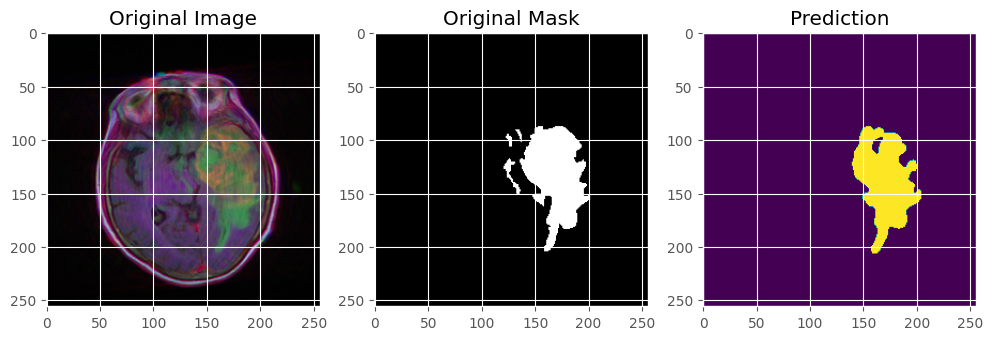

1/1 [==============================] - 0s 21ms/step


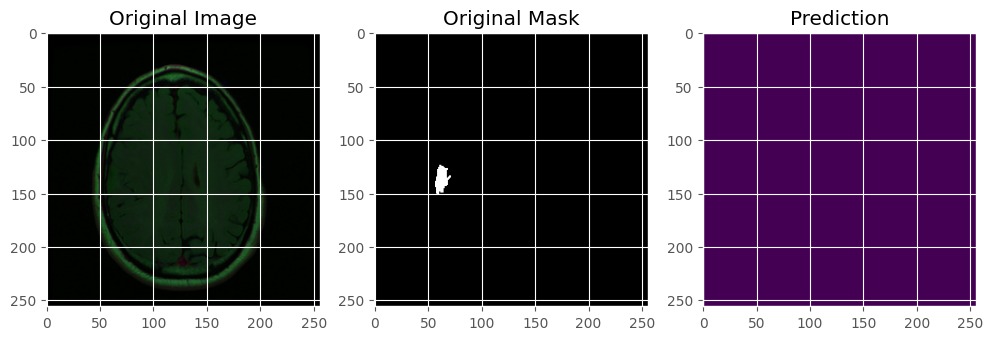

1/1 [==============================] - 0s 19ms/step


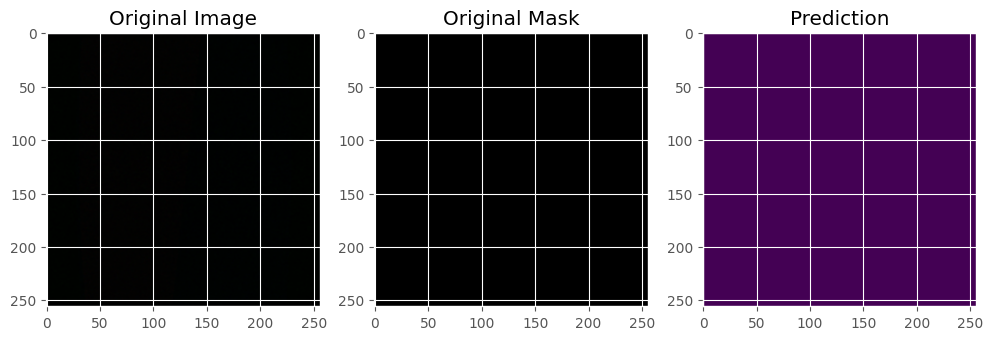

1/1 [==============================] - 0s 19ms/step


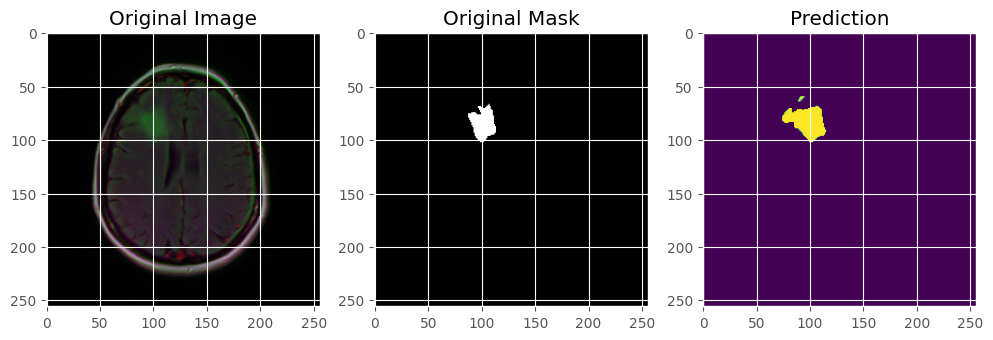

1/1 [==============================] - 0s 19ms/step


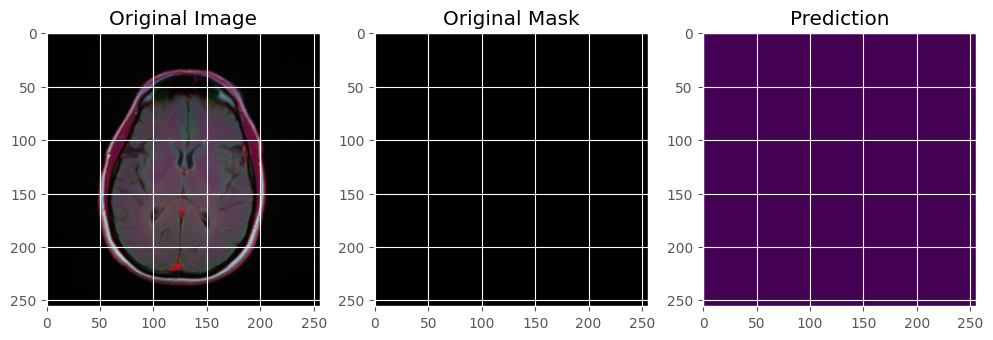

1/1 [==============================] - 0s 19ms/step


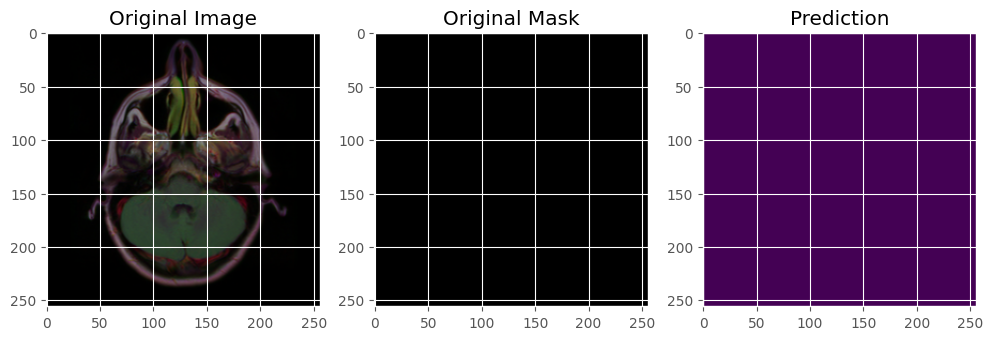

1/1 [==============================] - 0s 21ms/step


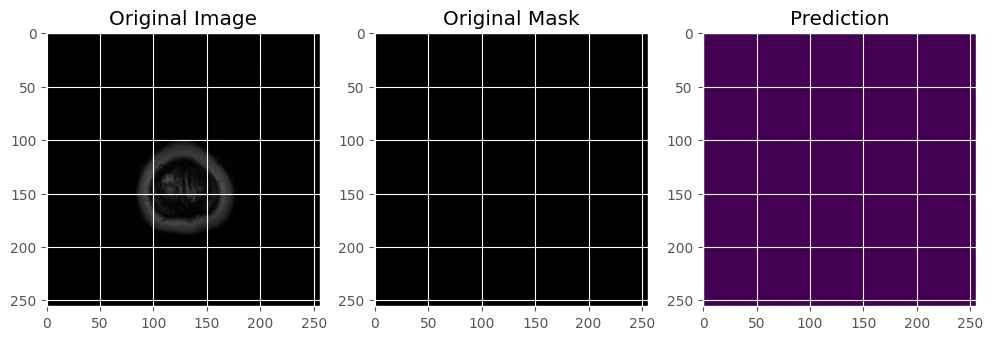

1/1 [==============================] - 0s 20ms/step


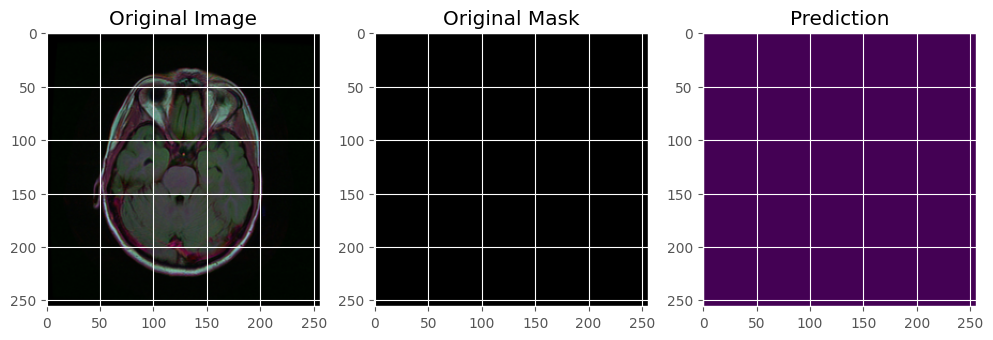

1/1 [==============================] - 0s 20ms/step


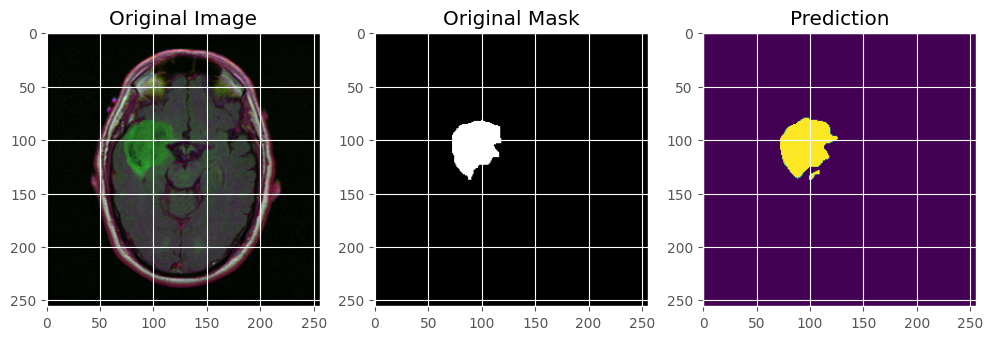

1/1 [==============================] - 0s 20ms/step


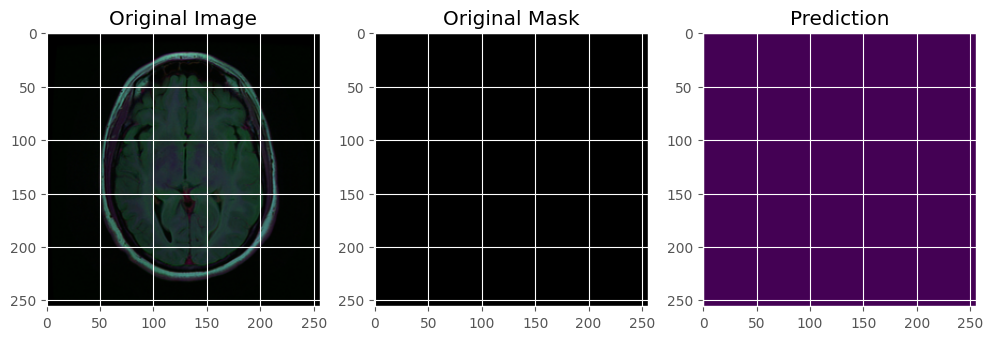

1/1 [==============================] - 0s 20ms/step


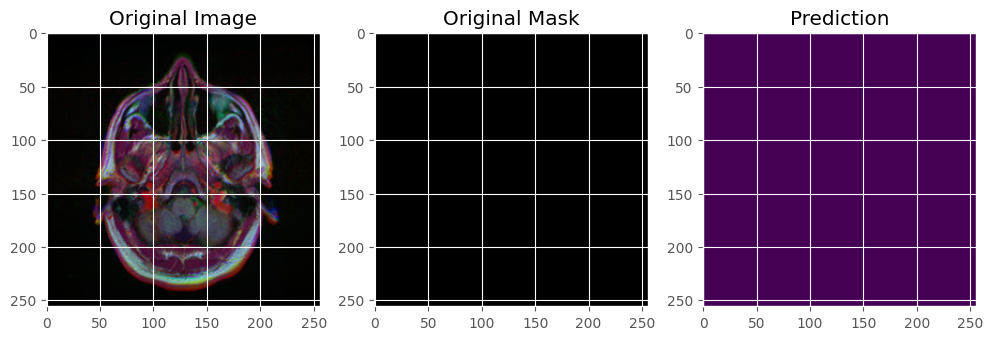

1/1 [==============================] - 0s 19ms/step


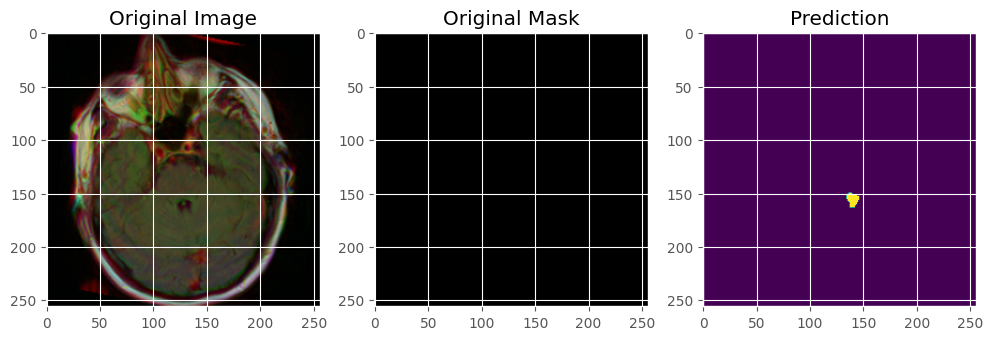

1/1 [==============================] - 0s 29ms/step


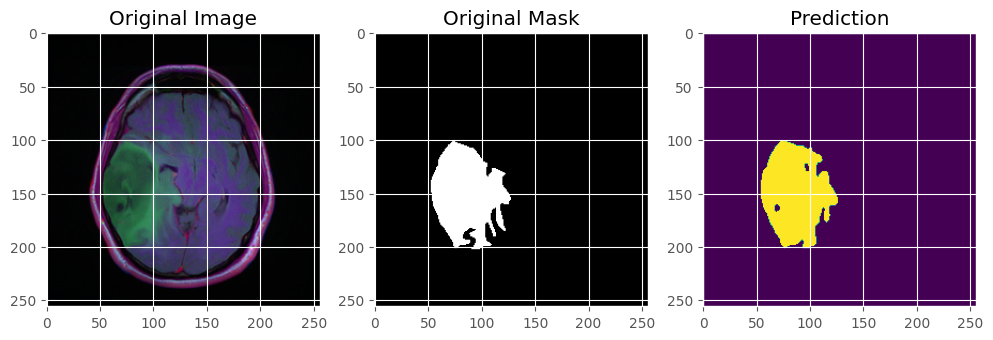

1/1 [==============================] - 0s 18ms/step


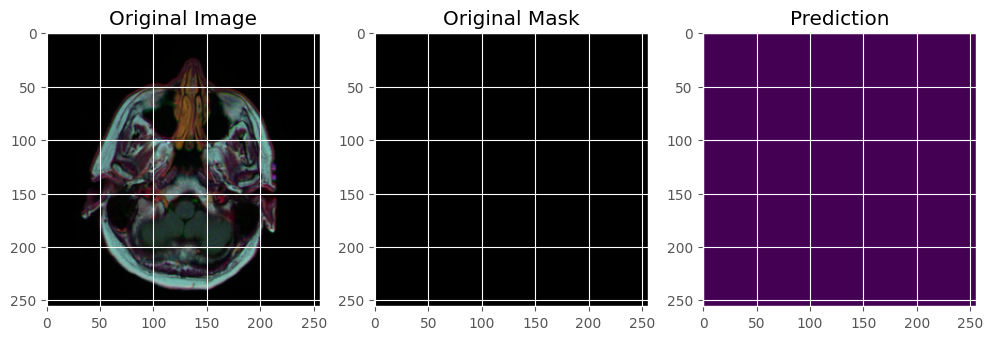

1/1 [==============================] - 0s 19ms/step


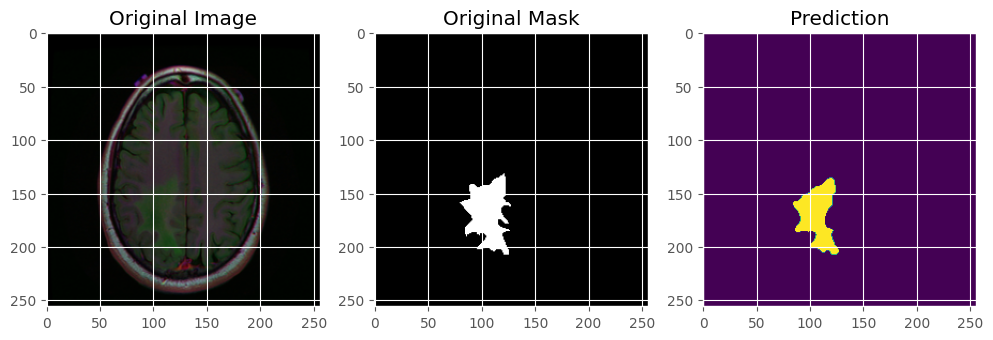

1/1 [==============================] - 0s 17ms/step


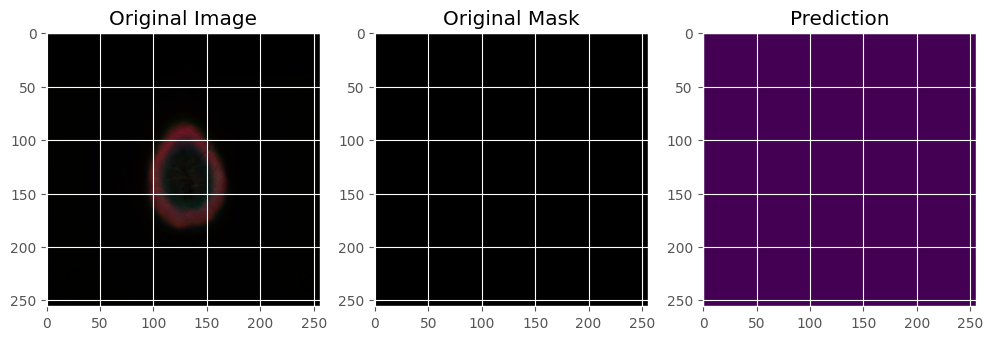

1/1 [==============================] - 0s 19ms/step


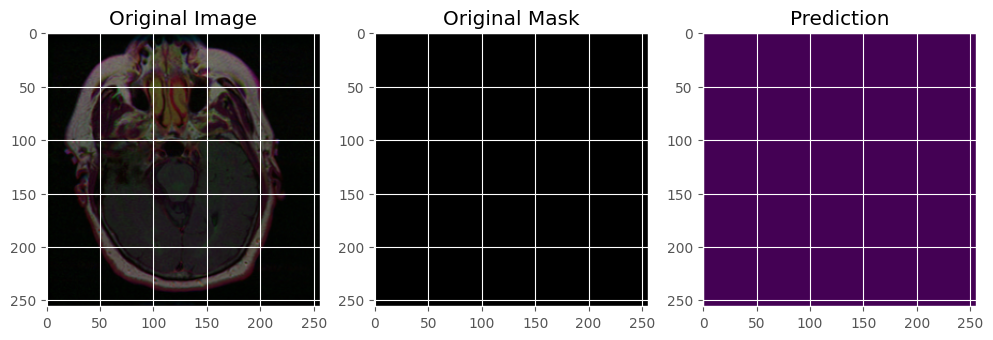

1/1 [==============================] - 0s 24ms/step


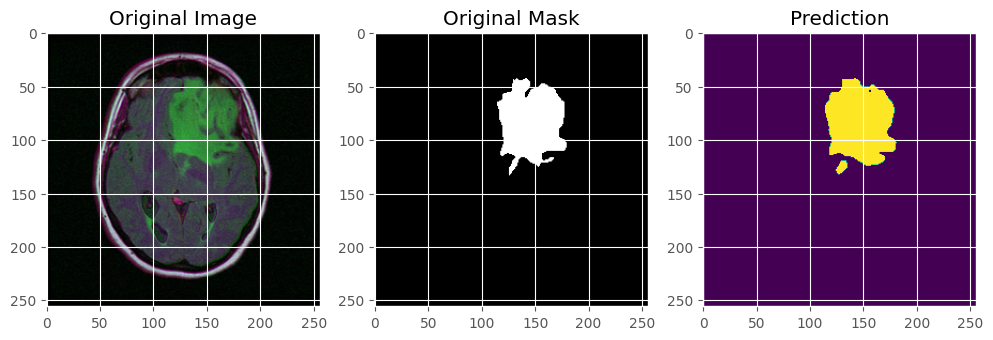

1/1 [==============================] - 0s 19ms/step


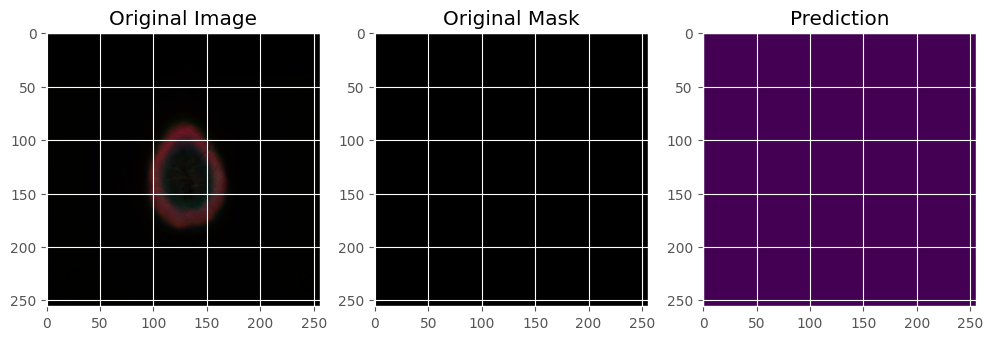

1/1 [==============================] - 0s 18ms/step


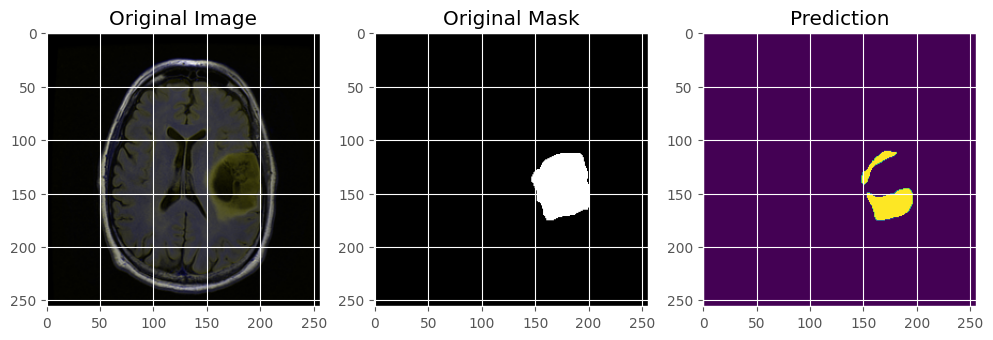

1/1 [==============================] - 0s 19ms/step


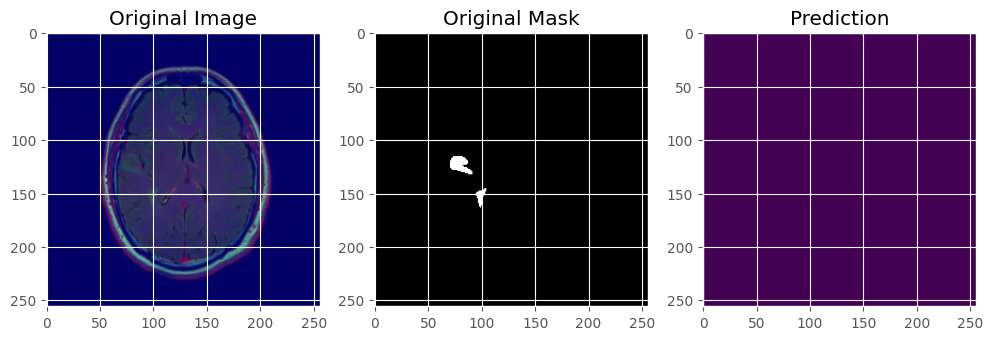

1/1 [==============================] - 0s 19ms/step


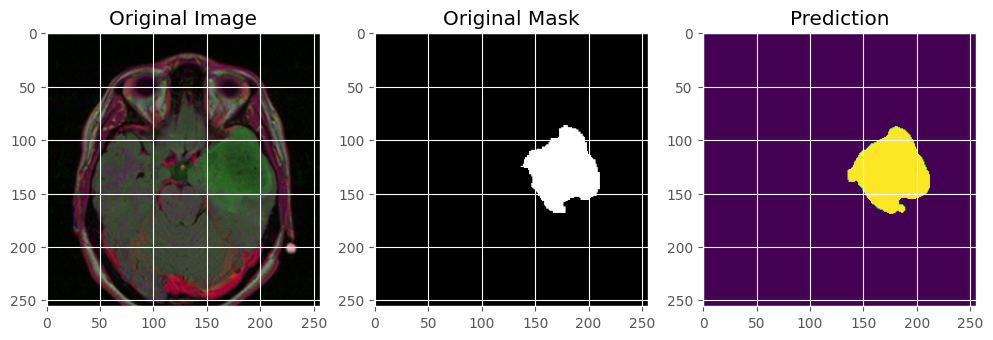

1/1 [==============================] - 0s 18ms/step


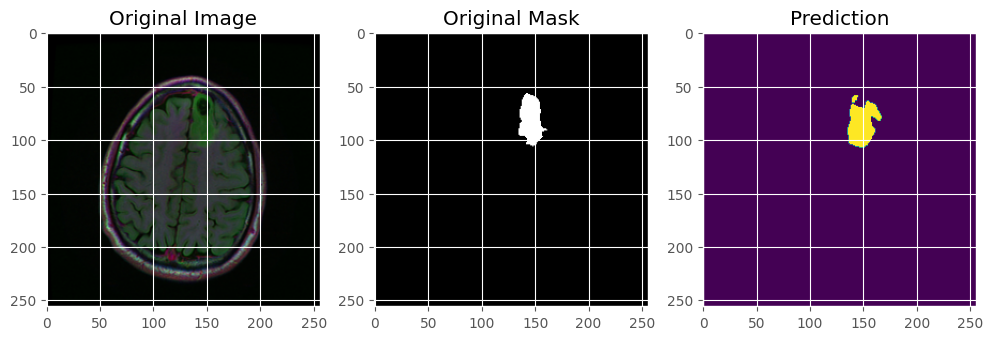

1/1 [==============================] - 0s 17ms/step


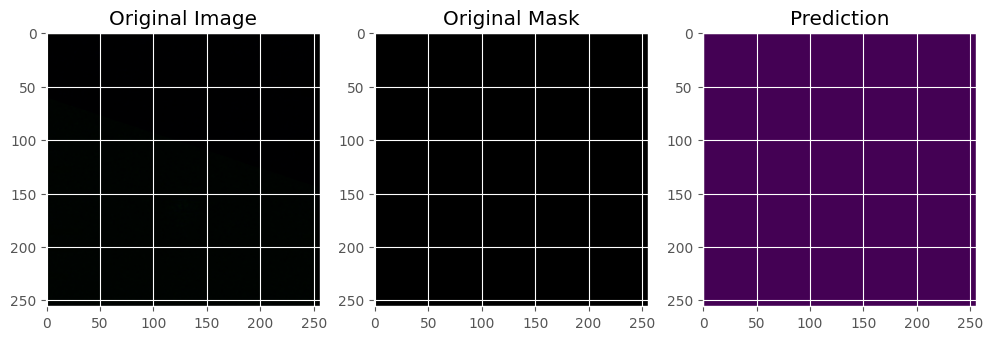

1/1 [==============================] - 0s 23ms/step


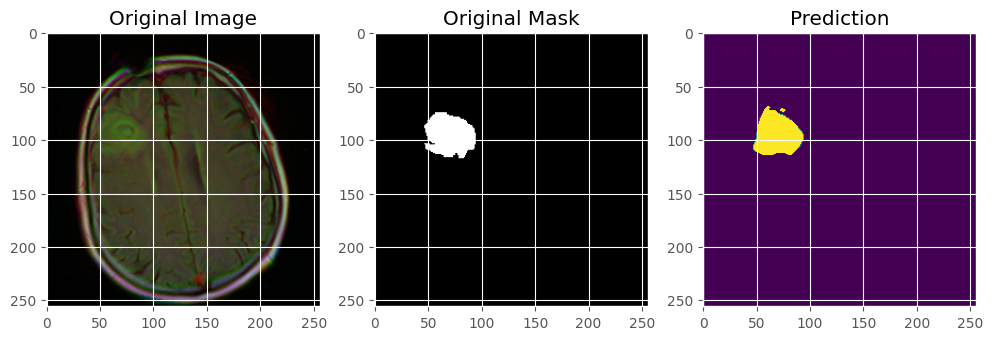

1/1 [==============================] - 0s 22ms/step


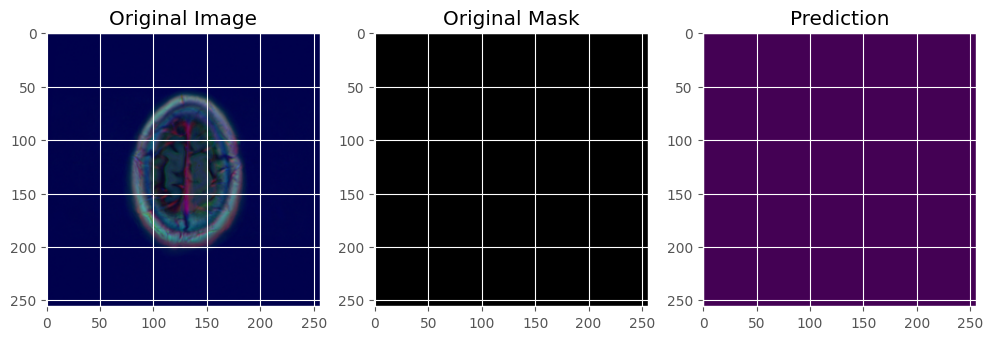

1/1 [==============================] - 0s 18ms/step


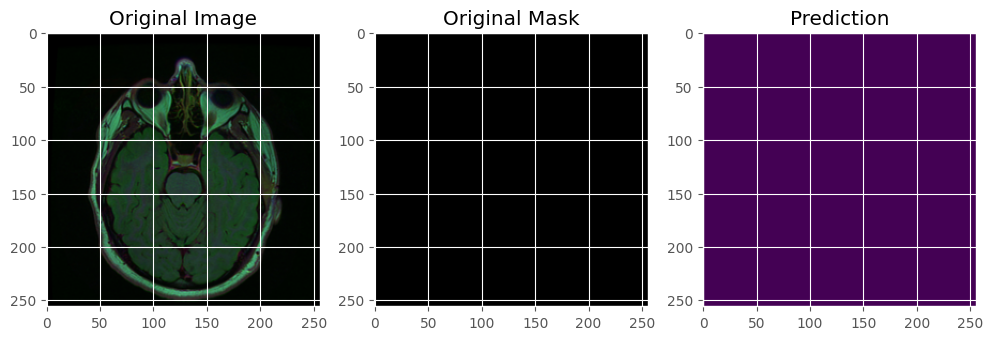

1/1 [==============================] - 0s 19ms/step


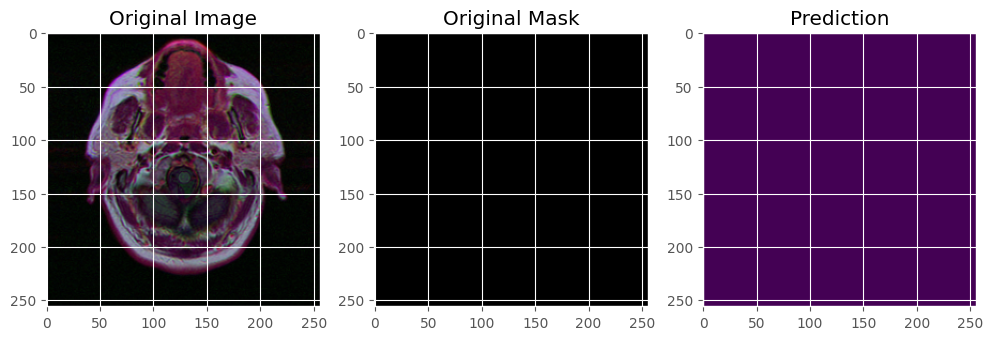

1/1 [==============================] - 0s 18ms/step


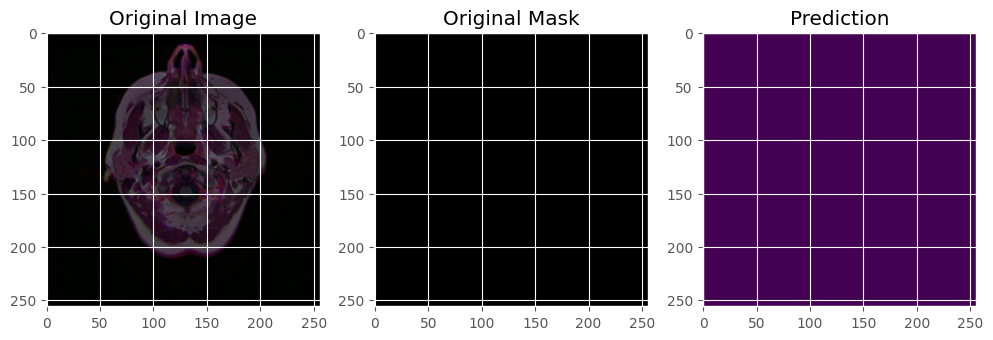

1/1 [==============================] - 0s 19ms/step


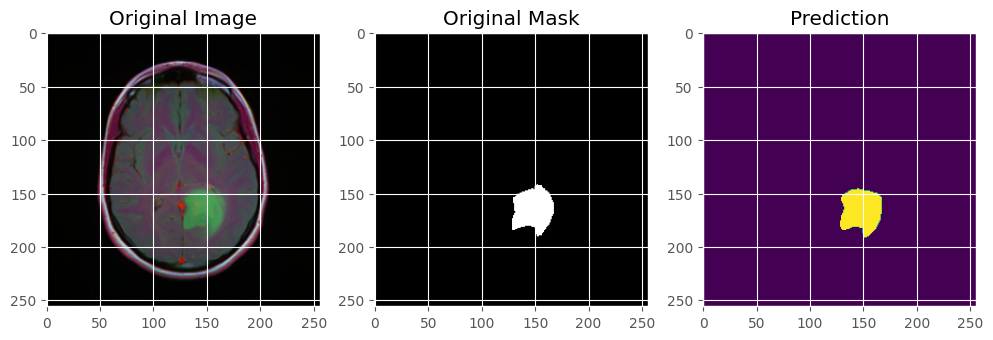

1/1 [==============================] - 0s 22ms/step


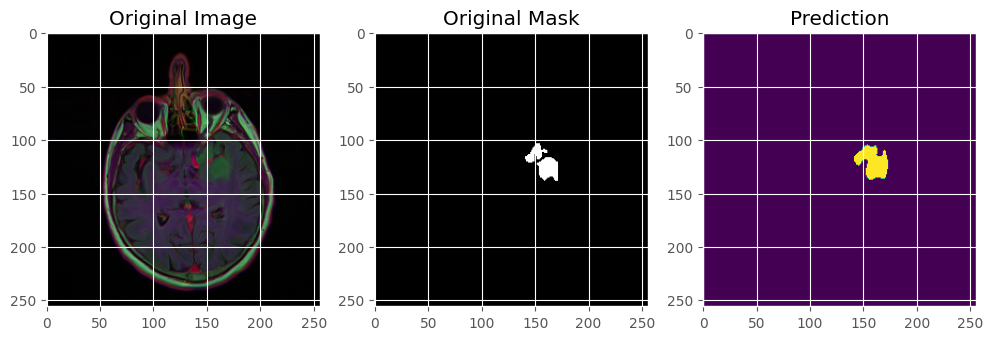

1/1 [==============================] - 0s 19ms/step


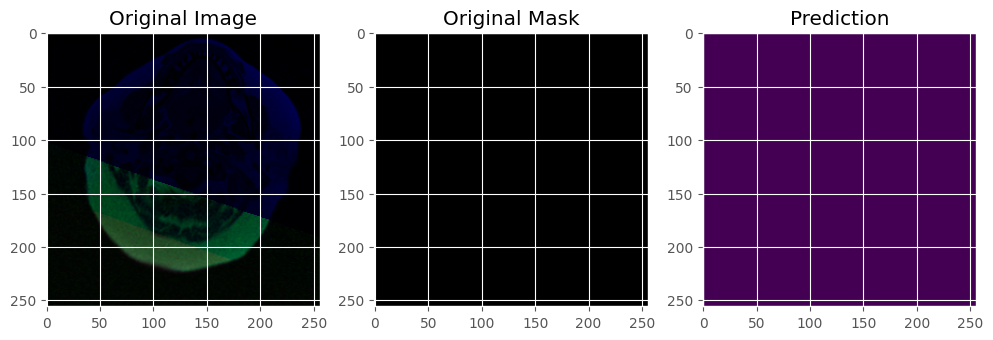

1/1 [==============================] - 0s 19ms/step


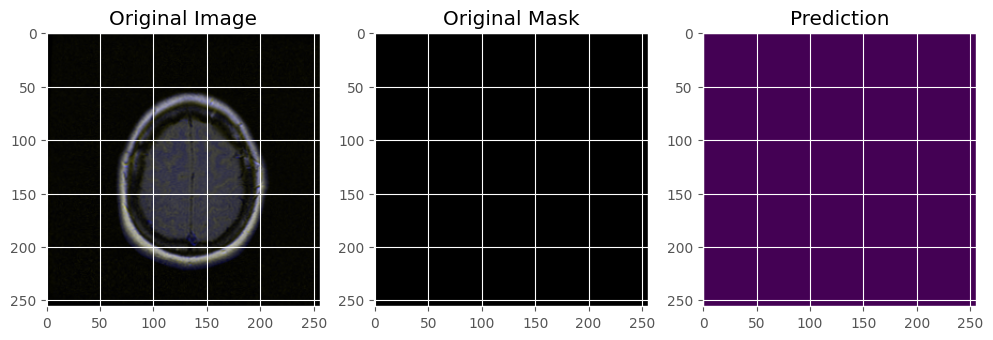

1/1 [==============================] - 0s 19ms/step


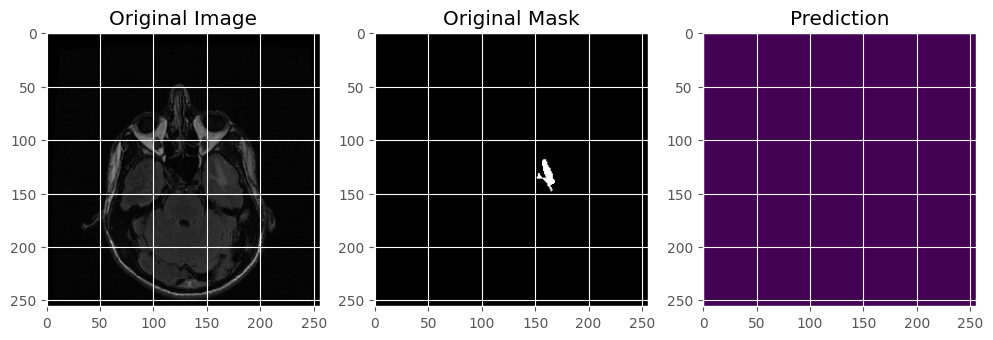

1/1 [==============================] - 0s 19ms/step


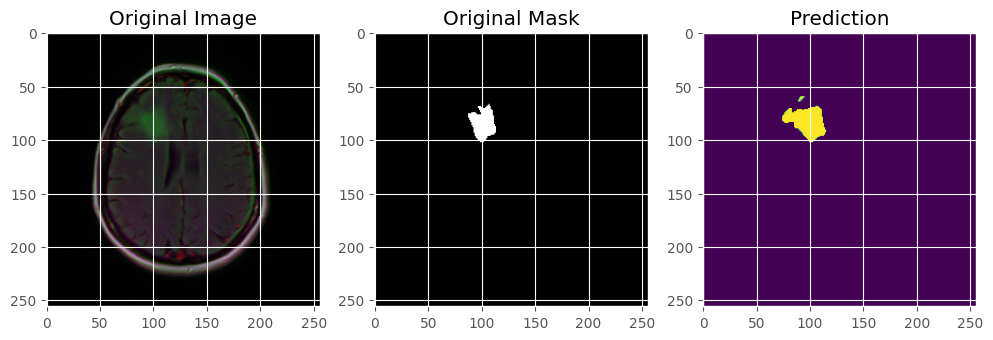

1/1 [==============================] - 0s 24ms/step


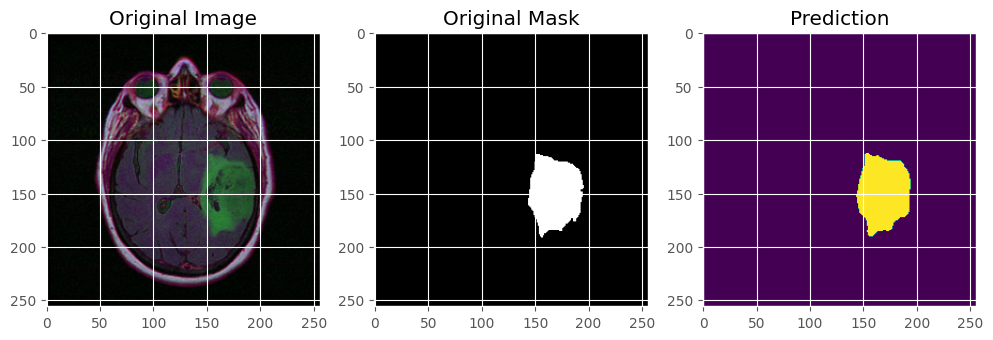

1/1 [==============================] - 0s 18ms/step


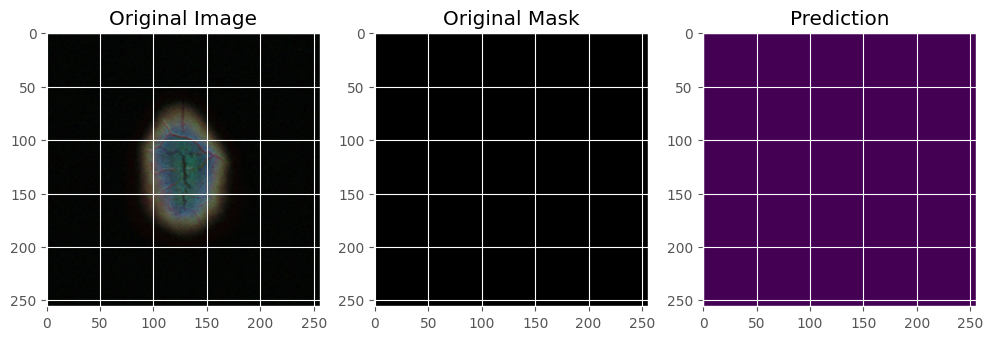

1/1 [==============================] - 0s 18ms/step


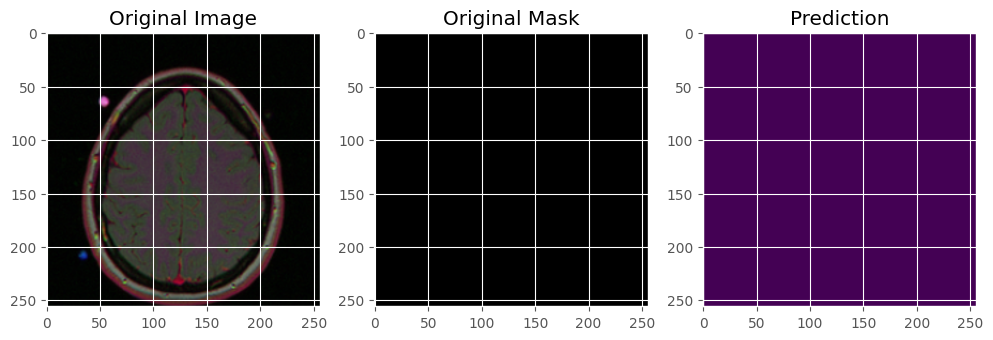

1/1 [==============================] - 0s 18ms/step


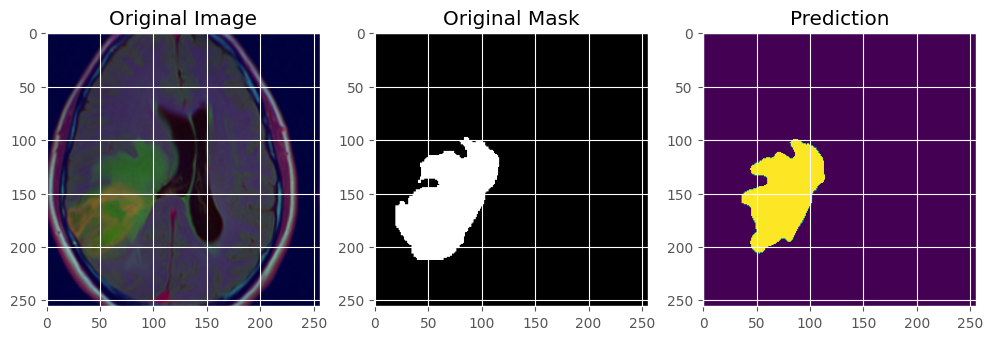

1/1 [==============================] - 0s 19ms/step


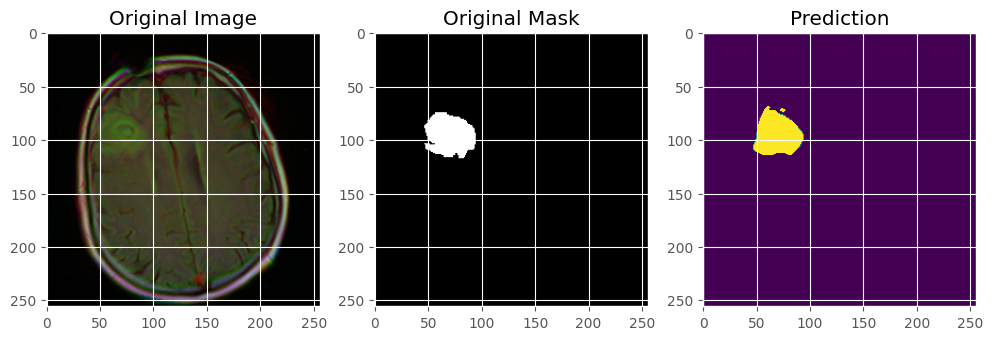

1/1 [==============================] - 0s 19ms/step


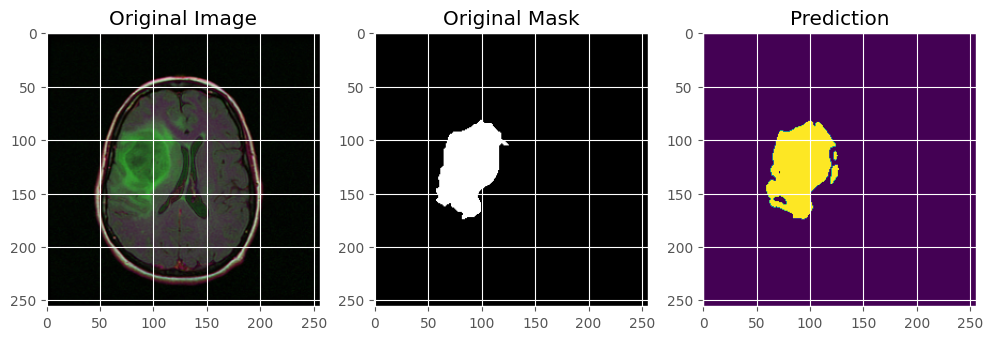

1/1 [==============================] - 0s 18ms/step


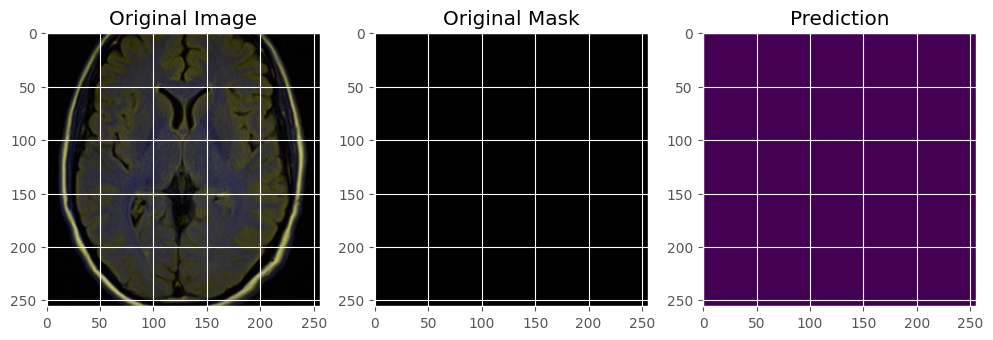

1/1 [==============================] - 0s 20ms/step


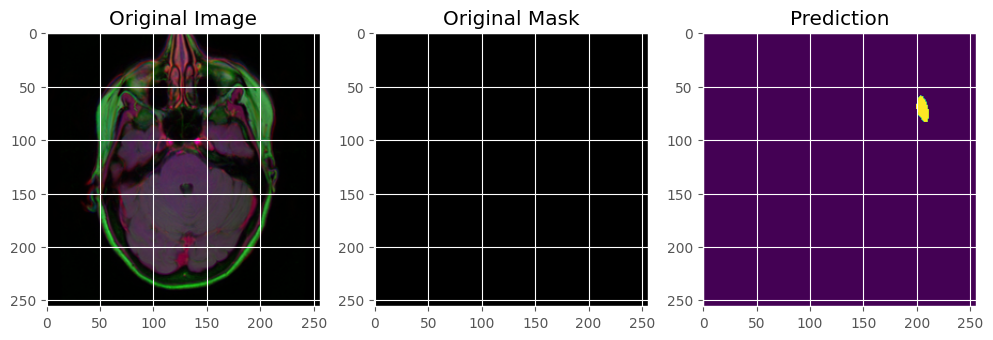

1/1 [==============================] - 0s 19ms/step


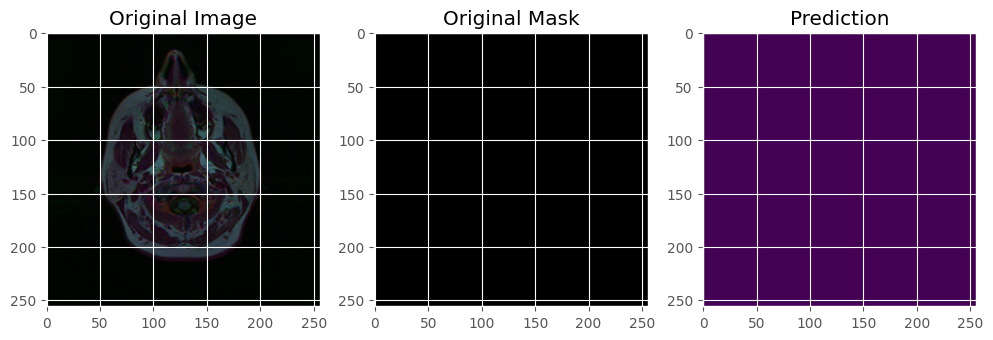

1/1 [==============================] - 0s 18ms/step


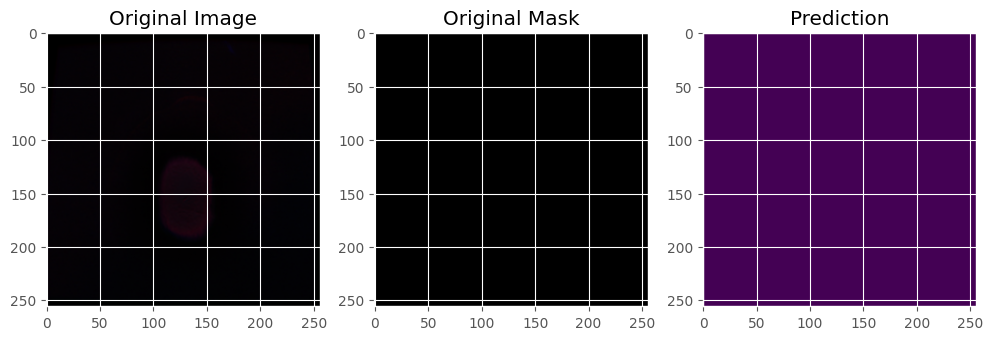

1/1 [==============================] - 0s 19ms/step


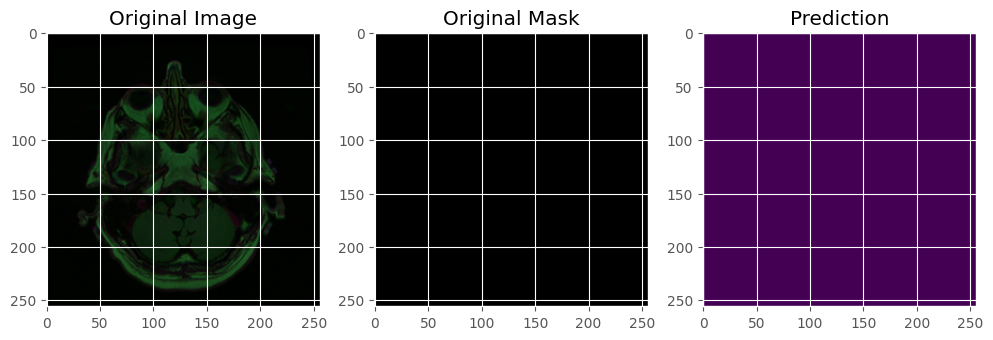

1/1 [==============================] - 0s 17ms/step


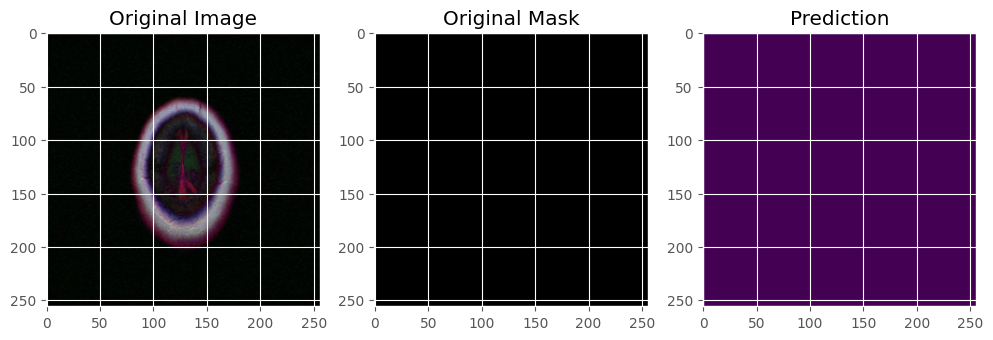

1/1 [==============================] - 0s 19ms/step


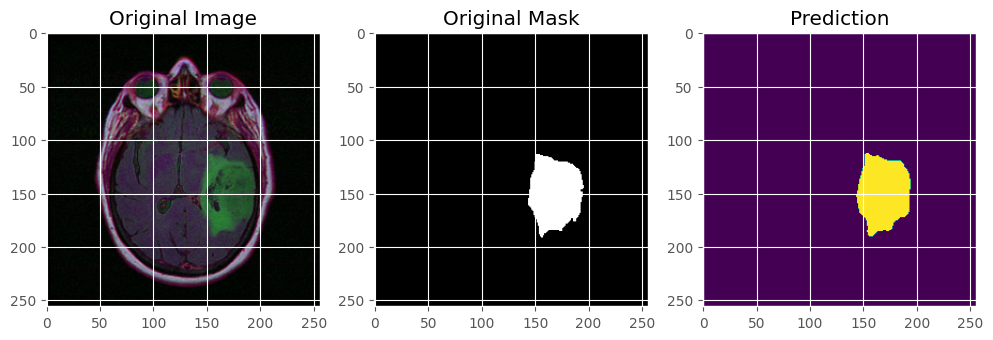

1/1 [==============================] - 0s 18ms/step


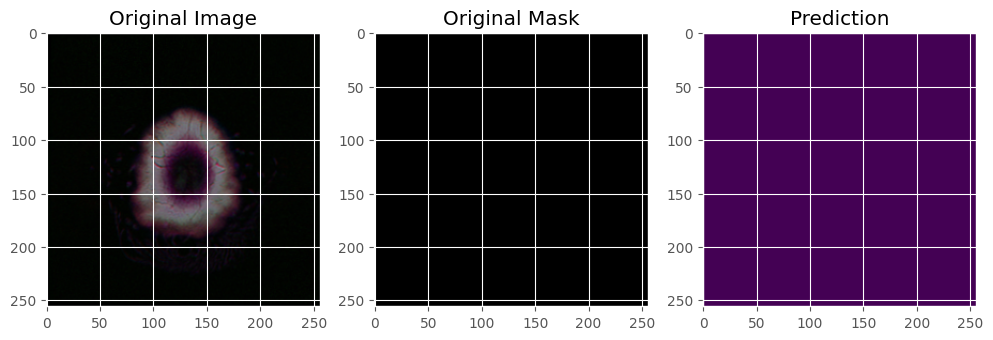

1/1 [==============================] - 0s 17ms/step


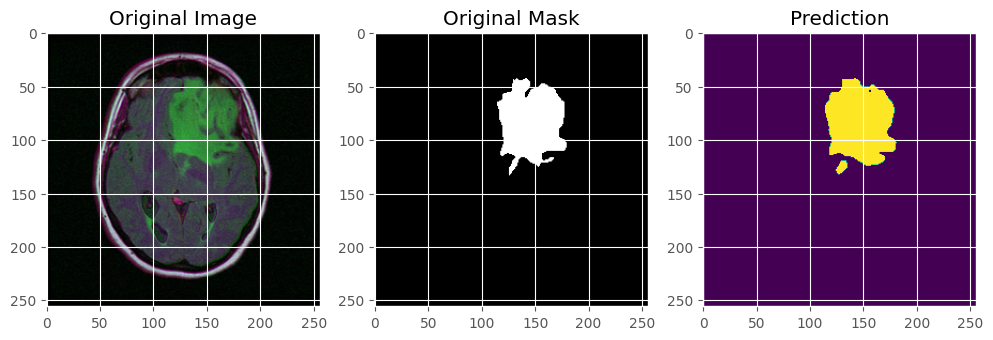

In [ ]:
for i in range(15):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['filename'].iloc[index])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()